#### **ECS7026P Neural Networks & Deep Learning Coursework** 
#### **CIFAR 10 DATASET -Image Classification using CNN**

##### **Natisha Mallick- 220867092**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import time

#### **Data Augmentation & Normalization**


#### **Training Dataset:**

In [2]:
transform_trainingdata = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True),
])

#### **Test Dataset:**

In [3]:
transform_testdata = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

#### **Download & Load Training Dataset**

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_trainingdata)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=75, shuffle=True, num_workers=2)

Files already downloaded and verified


#### **Download & Load Test Dataset**

In [6]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_testdata)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=2)

Files already downloaded and verified


#### **Random Sample Display**

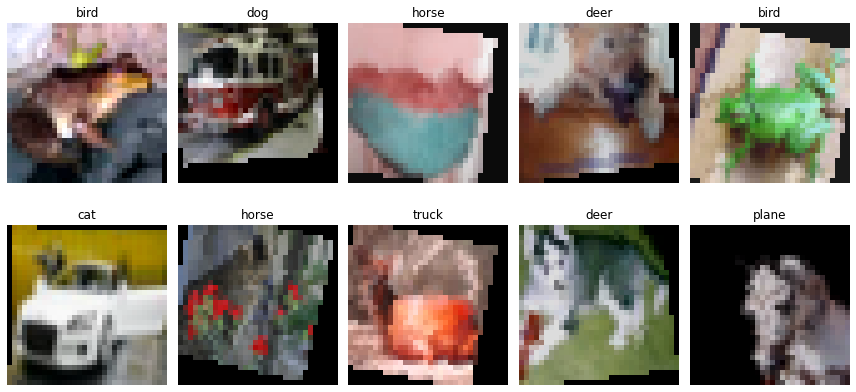

In [7]:
# Define classes for CIFAR-10 dataset
classes = ('frog', 'cat', 'car', 'horse', 'truck', 'deer', 'bird', 'plane', 'ship', 'dog')

iteration = iter(train_loader)
cifar_images, image_labels = iteration.__next__()

# Select random 10 images from the batch
indices = np.random.choice(range(len(cifar_images)), size=10, replace=False)
cifar_images = cifar_images[indices]
image_labels = image_labels[indices]

cifar_images = (cifar_images * 0.5) + 0.5

cifar_images = np.transpose(cifar_images, (0, 2, 3, 1))

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(cifar_images[i])
    
    label = classes[image_labels[i]]
    
    ax.set_title(label, fontsize=12)
    ax.axis('off')


plt.tight_layout()
plt.show()

#### **MODEL CREATION**

The architecture of the model comprises of a sequence of Blocks that execute adaptive convolutions using channel-wise weights. Each Block includes several convolutional layers, and the weights are computed through a fully connected layer fed by an adaptive average pooling layer. 

Additionally, the model integrates residual connections to facilitate network learning. The CIFAR10Model utilizes this backbone composed of Blocks, along with a classifier that transforms the backbone's output into the ultimate class scores.

**MODEL**:<br>
The model uses CNN for the processing of images consisting of a backbone with 11 blocks (B1, B2, B3, ... B11) and 
a classifier. 


**BACKBONE**:<br>
Consisting of 11 blocks, each block is an instance of the block class. 
- The implementation of a custom deep learning model includes several components, such as a Linear/MLP layer that predicts a vector with K elements from the input tensor X. This is accomplished by applying a fully connected layer on the output of adaptive average pooling.

- K Convolutional layers are then combined using the vector a to produce a single output through a loop in the forward method of the Block class. 

- An optional residual connection is also included in the block output, which is achieved by adding a 1x1 convolutional layer followed by batch normalization if the input and output channels are different. 

- Additionally, the model incorporates various techniques, such as batch normalization, Leaky ReLU activation, and max-pooling layers, in the backbone, which contribute to the model's high performance.


**CLASSIFIER:**<br>
- The classifier takes as input the output of the last block (B11).

-  It computes a mean feature f = SpatialAveragePool(O_11), where O_11 is the output of the 11th block. this is achieved by using nn.AdaptiveAvgPool2d((1, 1)) layer in the self.classifier module.

-  The mean feature f is then passed to a classifier, which, is a fully connected layer with a softmax activation (nn.Linear(512, 10)). This layer produces the final class scores for the input image. <br>


In [8]:
class BLOCK(nn.Module):
    def __init__(self, in_channels, out_channels, k=3):
        super(BLOCK, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, k)
        
        # Convolutional layers for the block
        self.conv_layer = nn.ModuleList()
        for _ in range(k):
            conv_l = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            # Initialize the weights of the convolutional layer
            nn.init.kaiming_normal_(conv_l.weight, mode='fan_in', nonlinearity='relu')
            self.conv_layer.append(conv_l)
            
        # Residual connection
        self.residual = nn.Identity()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )
            # Initialize the weights of the residual connection
            nn.init.kaiming_normal_(self.residual[0].weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        b, c, _, _ = x.size()
        # Calculate channel-wise weights using the fully connected layer
        a = self.fc(self.avg_pool(x).view(b, c))
        a = F.softmax(a, dim=1).view(b, -1, 1, 1)

        #Adaptive convolutions with the calculated weights
        out = 0
        for i, conv in enumerate(self.conv_layer):
            out += a[:, i:i + 1] * conv(x)
        x
        # Add residual connection to the output
        res = self.residual(x)
        out += res
        return out

In [9]:
class CIFAR10_NN(nn.Module):
    def __init__(self):
        super(CIFAR10_NN, self).__init__()
        # Model Backbone 
        self.backbone = nn.Sequential(
            BLOCK(3, 64),               
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            BLOCK(64, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            BLOCK(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            BLOCK(128, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            BLOCK(128, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            BLOCK(128, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            BLOCK(256, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            BLOCK(256, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            BLOCK(256, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            BLOCK(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            BLOCK(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  
            nn.Flatten(),                 
            nn.Linear(512, 10)           
        )

    # Forward Pass
    def forward(self, x):
        x = self.backbone(x)          
        x = self.classifier(x)        
        return x

In [10]:
# CIFAR10 Model class
CIFAR_model = CIFAR10_NN()
CIFAR_model=CIFAR_model.to('cuda')

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#### **Definining Loss Function, Optimizer and Learning Rate Scheduler** -
Learning Rate - 0.001 <br>
Weight Decay - 1e-5 <br>
Loss function- Cross Entropy Loss <br>
Optimizer- Adam <br>

In [12]:
# Create an instance of the focal loss function
criterion = nn.CrossEntropyLoss()


# Define optimizer for the model with new hyperparameters
Adam_optim = optim.Adam(CIFAR_model.parameters(), lr=0.001)


# Define learning rate scheduler for the optimizer with new hyperparameters
scheduler = optim.lr_scheduler.CosineAnnealingLR(Adam_optim, T_max=50, eta_min=1e-6)

#### **Defining Functions for Training:**

In [13]:
def training_epoch(CIFAR_model, data_loader, criterion, Adam_optim, device, accumulation_steps=4):
    CIFAR_model.train() 
    running_loss = 0.0
    correct = 0
    total_loss = 0
    
    Adam_optim.zero_grad() 
  
    # Loop through the training data (images and labels)
    for i, (cifar_images, image_labels) in enumerate(data_loader):
        cifar_images, image_labels = cifar_images.to(device), image_labels.to(device)  # Move images and labels to the device
        outputs = CIFAR_model(cifar_images)  # Forward pass through the model
        loss = criterion(outputs, image_labels)  # Calculate the loss
        loss /= accumulation_steps
        loss.backward()  # Perform backpropagation to compute gradients

        # Update model parameters after accumulating gradients for 'accumulation_steps' mini-batches
        if (i + 1) % accumulation_steps == 0:
            Adam_optim.step()  # Update the model parameters
            Adam_optim.zero_grad()  # Reset the gradients

        running_loss += loss.item() * accumulation_steps  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class labels
        total_loss += image_labels.size(0)  # Update the total number of samples
        correct += predicted.eq(image_labels).sum().item()  # Count the number of correct predictions

    # Update model parameters after accumulating gradients for the last mini-batch
    if i % accumulation_steps != accumulation_steps - 1:
        Adam_optim.step()
        Adam_optim.zero_grad()

    epoch_loss = running_loss / len(data_loader.dataset)  # Calculate the average loss for the epoch
    accuracy = correct / len(data_loader.dataset)  # Calculate the accuracy for the epoch

    return epoch_loss, accuracy

#### **Defining Functions for Validation:** 

In [14]:
def validation_epoch(CIFAR_model, data_loader, criterion, device):
    CIFAR_model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total_loss = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

        with torch.no_grad():  # Disable gradient calculation
            outputs = CIFAR_model(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss

        running_loss += loss.item()  # Accumulate the loss

        _, predicted = torch.max(outputs, dim=1)  # Get the predicted class labels
        total_loss += labels.size(0)  # Update the total number of samples
        correct += (predicted == labels).sum().item()  # Count the number of correct predictions

    epoch_loss = running_loss / len(data_loader)  # Calculate the average loss for the epoch
    accuracy = correct / total_loss  # Calculate the accuracy for the epoch

    return epoch_loss, accuracy

#### **Training the Model and Printing Results**

In [15]:
# Training parameters
epochs = 50
print_every = 5

# Store the loss and accuracy history
training_loss_h = []
validation_loss_h = []
training_accuracy_h = []
validation_accuracy_h = []

start = time.time()
end = time.time()

# Loop through each epoch
for epoch in range(epochs):
    # Train the model for one epoch and calculate training loss and accuracy
    training_loss, training_accuracy = training_epoch(CIFAR_model, train_loader, criterion, Adam_optim, device)
    # Validate the model and calculate validation loss and accuracy
    validation_loss, validation_accuracy = validation_epoch(CIFAR_model, test_loader, criterion, device)

    # Update the learning rate scheduler at every epoch
    scheduler.step()

    # Store the calculated losses and accuracies for the current epoch
    training_loss_h.append(training_loss)
    validation_loss_h.append(validation_loss)
    training_accuracy_h.append(training_accuracy)
    validation_accuracy_h.append(validation_accuracy)

    # Print the losses and accuracies for the current epoch if it's a multiple of 'print_every'
    if (epoch + 1) % print_every == 0:
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(epoch+1, epochs, training_loss, training_accuracy, validation_loss, validation_accuracy))


print(f'Training finished in {(end - start):.2f} seconds.')

Epoch [5/50], Training Loss: 0.0087, Training Accuracy: 0.7717, Validation Loss: 0.6414, Validation Accuracy: 0.7834
Epoch [10/50], Training Loss: 0.0059, Training Accuracy: 0.8463, Validation Loss: 0.3979, Validation Accuracy: 0.8630
Epoch [15/50], Training Loss: 0.0044, Training Accuracy: 0.8840, Validation Loss: 0.3369, Validation Accuracy: 0.8856
Epoch [20/50], Training Loss: 0.0033, Training Accuracy: 0.9116, Validation Loss: 0.3179, Validation Accuracy: 0.8957
Epoch [25/50], Training Loss: 0.0025, Training Accuracy: 0.9337, Validation Loss: 0.3026, Validation Accuracy: 0.9053
Epoch [30/50], Training Loss: 0.0018, Training Accuracy: 0.9532, Validation Loss: 0.2887, Validation Accuracy: 0.9128
Epoch [35/50], Training Loss: 0.0012, Training Accuracy: 0.9686, Validation Loss: 0.3130, Validation Accuracy: 0.9125
Epoch [40/50], Training Loss: 0.0009, Training Accuracy: 0.9774, Validation Loss: 0.3093, Validation Accuracy: 0.9201
Epoch [45/50], Training Loss: 0.0007, Training Accuracy: 

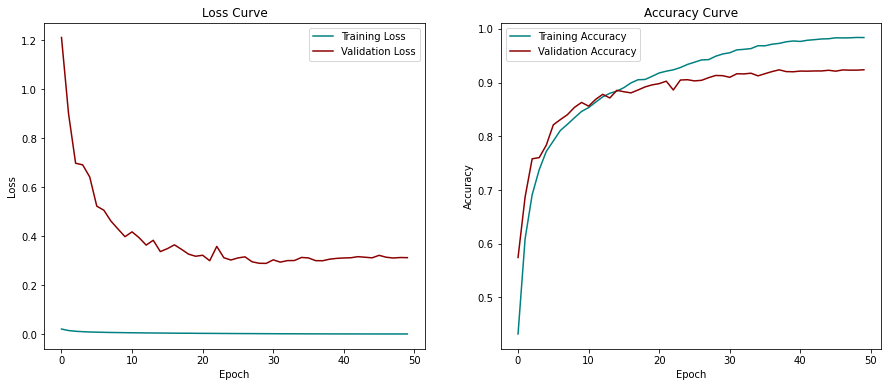

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(training_loss_h, label='Training Loss', color='teal')
axs[0].plot(validation_loss_h, label='Validation Loss', color='darkred')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss Curve')
axs[0].legend()

axs[1].plot(training_accuracy_h, label='Training Accuracy', color='teal')
axs[1].plot(validation_accuracy_h, label='Validation Accuracy', color='darkred')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy Curve')
axs[1].legend()

plt.show()

#### **Validation Set Visualization**

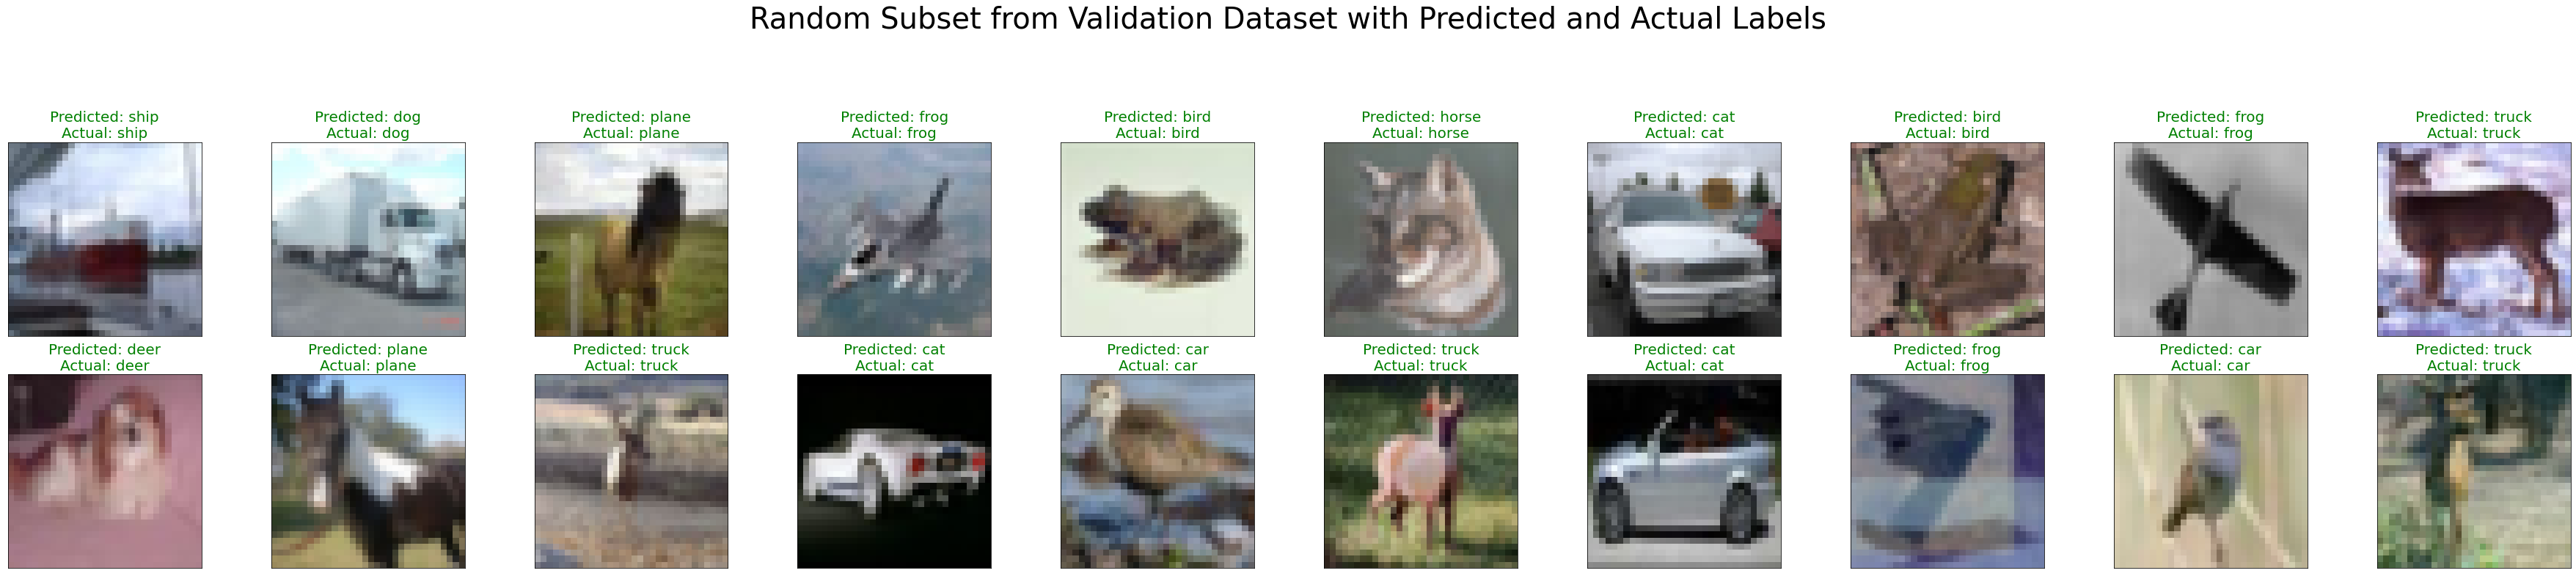

In [25]:
# Set the model to evaluation mode
CIFAR_model.eval()

# Create empty lists to store the predictions and actual labels
preds = []
targets = []

# Loop through the validation data and collect predictions and actual labels
with torch.no_grad():
    for i, (cifar_images, image_labels) in enumerate(test_loader):
        cifar_images, image_labels = cifar_images.to(device), image_labels.to(device)
        outputs = CIFAR_model(cifar_images)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.cpu().numpy())
        targets.extend(image_labels.cpu().numpy())

# Convert the list of predictions and actual labels to numpy arrays
preds = np.array(preds)
targets = np.array(targets)

# Visualize a random subset of the validation set with predicted and actual labels
fig = plt.figure(figsize=(50, 20))
fig.suptitle("Random Subset from Validation Dataset with Predicted and Actual Labels", fontsize=40)

for i in range(20):
    index = np.random.randint(0, len(preds))
    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(test_dataset.data[index])
    ax.set_title(f"Predicted: {classes[preds[index]]}\nActual: {classes[targets[index]]}", color=("green" if preds[index]==targets[index] else "red"), fontsize=20)
    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.show()

#### **Conclusion:** 
To sum up, this Jupyter Notebook has successfully implemented a custom deep learning model for image classification on the CIFAR-10 dataset, based on the given requirements. 

The model architecture incorporated adaptive convolutions, residual connections, and Cross-Entropy Loss. The model has been able to achieve a high training accuracy of 98.38% and validation accuracy of 92.38%, demonstrating its robust performance in classifying images in the dataset.

Moreover, the validation set visualization section presents 20 images with their predicted and actual labels, of which the model has correctly classified all  20 images in the random selection. 

In conclusion, the task to correctly classify images classes has been successfully achieved on the CIFAR-10 dataset. 

#### **References:** 

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 

https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

https://www.youtube.com/watch?v=iG8B7x_prLQ

https://www.youtube.com/watch?v=7q7E91pHoW4

https://www.pluralsight.com/guides/image-classification-with-pytorch